# Benchmark simulation
In this tutorial we will solve a single phase flow problem defined in Sections 4.1 and 4.3 of [Flemisch et al. 2017](https://doi.org/10.1016/j.advwatres.2017.10.036). The simulation is based on the `SinglePhaseFlow` class, which is introduced in [this tutorial](./single_phase_flow.ipynb). We modify the model through domain, boundary conditions and constitutive laws. 
We also specify fluid and solid parameters. 

In addition to providing a runable setup for the benchmark problem, the tutorial illustrates a non-trivial extension to dimension-dependent permeability.
The benchmark study explored different discretization schemes. 
We therefore also show how to change from the default multi-point flux approximation to a two-point scheme.

We start off by importing the necessary packages, and make a shorthand for the single phase flow model class:

In [1]:
import porepy as pp
import numpy as np
from porepy.models.fluid_mass_balance import SinglePhaseFlow

### Benchmark 1
The default geometry is a unitary domain without any fractures. The benchmark problem is defined on the unit square and contains a set of fractures which we access in PorePy's library of fracture sets. Specifications on how to mesh the domain will be passed as parameters below.

We also define the boundary conditions to be of Dirichlet type on the west and east boundary with pressure values of 1 and 0, respectively.

In [2]:
class Benchmark1Geometry:
    def set_fractures(self) -> None:
        """Setting a fracture list from the fracture set library."""
        self._fractures = pp.applications.md_grids.fracture_sets.benchmark_2d_case_1()


class Benchmark1BCs:
    def bc_type_darcy_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Assign Dirichlet to the west and east boundaries. The rest are Neumann by default."""
        bounds = self.domain_boundary_sides(sd)
        bc = pp.BoundaryCondition(sd, bounds.west + bounds.east, "dir")
        return bc

    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Zero bc value on top, bottom and east, 1 on west side."""
        bounds = self.domain_boundary_sides(boundary_grid)
        values = np.zeros(boundary_grid.num_cells)
        values[bounds.west] = self.fluid.convert_units(1, "Pa")
        return values

We need to implement different permeability values depending on subdomain dimension. 
This is implemented in the `DimensionDependentPermeability` class of the `constitutive_laws` module, but we need to override the methods defining the values for the fractures.  
To complete the modifications to the `SinglePhaseFlow` model, we create a simple class overriding the `darcy_flux_discretization` method to allow specifying discretization scheme in the passed parameters.

In [3]:
class Benchmark1Permeability(pp.constitutive_laws.DimensionDependentPermeability):

    def fracture_permeability(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Permeability of fractures.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Cell-wise permeability operator.

        """
        size = sum([sd.num_cells for sd in subdomains])
        val = self.params.get("fracture_permeability", 1e-4)
        permeability = pp.wrap_as_dense_ad_array(self.solid.convert_units(val, "m^2"), size)
        return self.isotropic_second_order_tensor(subdomains, permeability)



class Xpfa:
    """Allow choosing between TPFA and MPFA."""
    def darcy_flux_discretization(self, subdomains: list[pp.Grid]) -> pp.ad.MpfaAd | pp.ad.TpfaAd:
        """Discretization object for the Darcy flux term.

        Parameters:
            subdomains: List of subdomains where the Darcy flux is defined.

        Returns:
            Discretization of the Darcy flux.

        """
        scheme = self.params.get("darcy_flux_discretization", "mpfa")
        if scheme.lower() == "mpfa":
            return pp.ad.MpfaAd(self.darcy_keyword, subdomains)
        elif scheme.lower() == "tpfa":
            return pp.ad.TpfaAd(self.darcy_keyword, subdomains)
        else:
            raise ValueError(f"Unknown discretization scheme {scheme}.")

We can now combine the extensions with the base class:

In [4]:
class Benchmark1Model(
    Xpfa,
    Benchmark1Geometry,
    Benchmark1BCs,
    Benchmark1Permeability,
    SinglePhaseFlow,
):
    """Combines all SinglePhaseFlow with adjustments as defined in the benchmark problem."""

We run one simulation with each of the fracture permeability values defined in the benchmark. We also change discretization scheme and, for good measure, grid type.

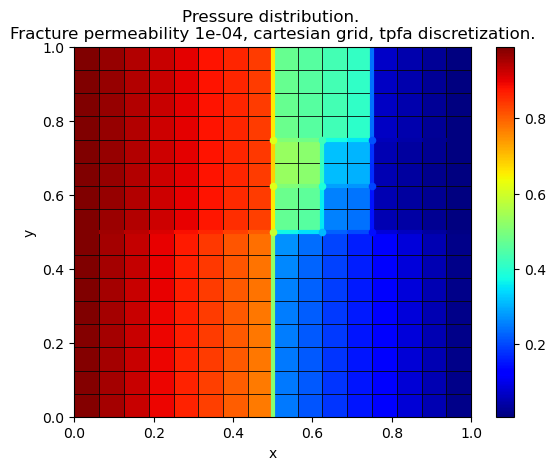

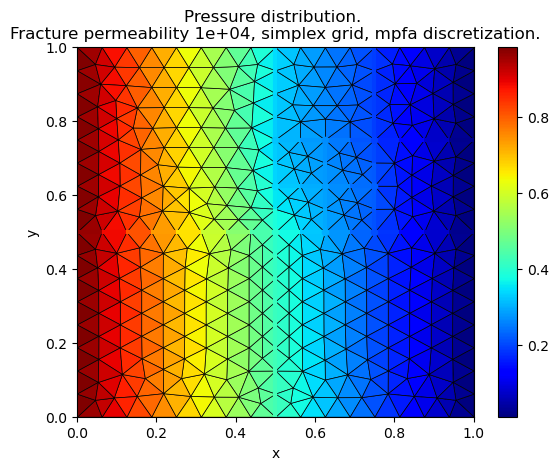

In [5]:
for k_f, grid, discr in zip([1e-4, 1e4], ["cartesian", "simplex"], ["tpfa", "mpfa"]):
    # We use default fluid parameters but tailored solid parameters.
    solid_constants = pp.SolidConstants({"residual_aperture": 1e-4, "normal_permeability": k_f})
    params = {
        "fracture_permeability": k_f,
        "material_constants": {"solid": solid_constants},
        "grid_type": grid,
        "meshing_arguments": {"cell_size": 1/16}
    }
    model = Benchmark1Model(params)
    pp.run_time_dependent_model(model, params)
    title = f"Pressure distribution. \nFracture permeability {k_f:.0e}, {grid} grid, {discr} discretization."
    pp.plot_grid(model.mdg, model.pressure_variable, figsize=(12, 10), plot_2d=True, title=title, pointsize=20, fracturewidth_1d=3, linewidth=0.5)

### Benchmark 3
We again use a fracture set from the library. 
The case is run with two sets of boundary conditions - flow from top to bottom and from left to right.

In [6]:
class Benchmark2Geometry:
    def set_fractures(self) -> None:
        """Setting a fracture list from the fracture set library."""
        self._fractures = pp.applications.md_grids.fracture_sets.benchmark_2d_case_3()


class Benchmark2BCsWestEast(Benchmark1BCs):
    """Flow from left to right.

    Reuses BC type definition from Benchmark1BCs, but changes the values.

    """
    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """Pressure value of 4 on left/west and 1 on right/east side."""
        bounds = self.domain_boundary_sides(boundary_grid)
        values = np.zeros(boundary_grid.num_cells)
        values[bounds.west] = self.fluid.convert_units(4, "Pa")
        values[bounds.east] = self.fluid.convert_units(1, "Pa")
        return values

class Benchmark2BCsNorthSouth:
    def bc_type_darcy_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Assign Dirichlet to the top and bottom boundaries. The rest are Neumann by default."""
        bounds = self.domain_boundary_sides(sd)
        bc = pp.BoundaryCondition(sd, bounds.north + bounds.south, "dir")
        return bc

    def bc_values_pressure(self, boundary_grid: pp.BoundaryGrid) -> np.ndarray:
        """bc value of 4 on top and 1 on bottom side."""
        bounds = self.domain_boundary_sides(boundary_grid)
        values = np.zeros(boundary_grid.num_cells)
        values[bounds.north] = self.fluid.convert_units(4, "Pa")
        values[bounds.south] = self.fluid.convert_units(1, "Pa")
        return values

The test case contains both high- and low-permeable fractures.
As per benchmark specification, normal intersection permeabilies are set to the harmonic average of the values for the fractures forming the intersection.

In [7]:
class Benchmark2Permeability(pp.constitutive_laws.DimensionDependentPermeability):

    @property
    def fracture_permeabilities(self) -> np.ndarray:
        """Permeability of the fractures.

        Ordering corresponds to definition of fractures in the geometry.

        """
        return np.array([1, 1, 1, 1e-8, 1e-8, 1, 1, 1, 1, 1]) * 1e4

    def fracture_permeability(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Permeability of fractures.

        Parameters:
            subdomains: List of subdomains.

        Returns:
            Cell-wise permeability operator.

        """
        if len (subdomains) == 0:
            return pp.wrap_as_dense_ad_array(1, size=0)
        permeabilities = []
        for sd in subdomains:
            permeabilities.append(
                self.solid.convert_units(
                    self.fracture_permeabilities[sd.frac_num] * np.ones(sd.num_cells), "m^2")
            )
        permeability = pp.wrap_as_dense_ad_array(np.concatenate(permeabilities))
        return self.isotropic_second_order_tensor(subdomains, permeability)

    def normal_permeability(self, interfaces: list[pp.MortarGrid]) -> pp.ad.Operator:
        """Permeability of intersections.

        Parameters:
            interfaces: List of interfaces.

        Returns:
            Cell-wise permeability operator.

        """
        if len (interfaces) == 0:
            return pp.wrap_as_dense_ad_array(1, size=0)
        permeabilities = []
        for intf in interfaces:
            # Get hold of the fracture subdomain.
            sd_high, sd_low = self.mdg.interface_to_subdomain_pair(intf)
            if intf.dim == 1:
                # The normal permeability equals the fracture permeability.
                val = self.fracture_permeabilities[sd_low.frac_num]
            else:
                # Get the fractures intersecting the interface.
                interfaces_lower = self.subdomains_to_interfaces([sd_low], [1])
                # Get the higher-dimensional neighbors.
                parent_subdomains = self.interfaces_to_subdomains(interfaces_lower)
                # Only consider the higher-dimensional neighbors, i.e. the fractures.
                fracture_permeabilities = [
                    self.fracture_permeabilities[sd.frac_num] for sd in parent_subdomains if sd.dim == intf.dim + 1
                ]
                unique_fracture_permeabilities = np.unique(fracture_permeabilities)
                val = unique_fracture_permeabilities.size / np.sum(1 / unique_fracture_permeabilities)
            permeabilities.append(self.solid.convert_units(val * np.ones(intf.num_cells), "m^2"))
        return pp.wrap_as_dense_ad_array(np.hstack(permeabilities), name="normal_permeability")

To visualize the permeability of the fractures, we make a model class, run prepare simulation and save permeabilities to the subdomain data dictionaries. 
We use logarithmic scale to discern between values $10^{-4}$, $1$ and $10^4$ and adjust the value of the harmonic mean of $10^{-4}$ and $10^4$ to distinguish it from $10^{-4}$.

C:\Users\ist050\AppData\Local\Temp\ipykernel_24036\2526181971.py:13: RuntimeWarning: divide by zero encountered in log10
  vals = np.log10(perm_model.permeability([sd]).value(perm_model.equation_system))


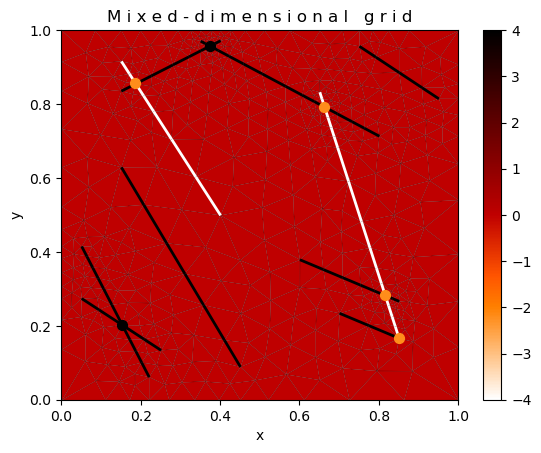

In [8]:
class Benchmark2Model(
    Xpfa,
    Benchmark2Geometry,
    Benchmark2Permeability,
    SinglePhaseFlow,
):
    """Combines SinglePhaseFlow with all adjustments as defined in the benchmark problem except BCs."""

perm_model = Benchmark2Model({"grid_type": "simplex", "meshing_arguments": {"cell_size": 0.2}})

perm_model.prepare_simulation()
for sd, data in perm_model.mdg.subdomains(return_data=True):
    vals = np.log10(perm_model.permeability([sd]).value(perm_model.equation_system))
    # Pick out xx component of permeability, which is represented as a cell-wise 9-vector.
    vals = vals.reshape((9, -1), order="F")[0]
    # 0d intersections have no notion of permeability. Instead, we check that the correct normal
    # permeability was assigned.
    if sd.dim == 0:
        # Find normal permeability of neighboring interfaces
        intf = perm_model.subdomains_to_interfaces([sd], codims=[1])
        all_vals = np.concatenate(
            [perm_model.normal_permeability([i]).value(perm_model.equation_system) for i in intf]
        )
        vals = np.log10(np.unique(all_vals))
        if np.isclose(vals[0], -3.69897001):
            vals += 1.5 # Hack to make the arithmetic mean distinguishable from the 10^-4 permeability.
        assert vals.size == 1, "Normal permeability is not constant."
    pp.set_solution_values("permeability", vals, data, time_step_index=0)

pp.plot_grid(perm_model.mdg, "permeability", plot_2d=True, color_map="gist_heat_r", pointsize=50, linewidth=0.1, fracturewidth_1d=2)


Since we have defined permeability inside the `Benchmark2Permeability` class above, the only parameters we need to specificy are aperture, grid type and cell size. 
Note how we mix in the BC classes inside the for loop to realize the two different benchmark sub-cases.

In [9]:
# We use default fluid parameters but tailored solid parameters.
solid_constants = pp.SolidConstants({"residual_aperture": 1e-4})
params = {
    "material_constants": {"solid": solid_constants},
    "grid_type": "simplex",
    "meshing_arguments": {"cell_size": 0.1}
}

for BCs, direction in zip([Benchmark2BCsWestEast, Benchmark2BCsNorthSouth], ["x", "y"]):
    class Benchmark2ModelWithBCs(BCs, Benchmark2Model):
        """Combines SinglePhaseFlow with all adjustments as defined in the benchmark problem."""

    model = Benchmark2ModelWithBCs(params)
    pp.run_time_dependent_model(model, params)
    title = f"Pressure distribution. \n Flow in {direction}-direction."
    pp.plot_grid(model.mdg, model.pressure_variable, figsize=(12, 10), plot_2d=True, title=title, pointsize=20, fracturewidth_1d=3, linewidth=0.5)

ValueError: Invalid keys in constants: {'aperture'}. 